# Preferential Bayesian Optimization: Dueling-Thompson Sampling

Implementation of the algorithm by Gonzalez et al (2017).

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import datetime
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
def log(message):
    print(str(datetime.datetime.now()) + ': ' + message)

In [3]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "DTS"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [4]:
num_runs = 2
num_evals = 2
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 1000 # TODO: CHANGE LATER!!

In [5]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/DTS/results/PBO_DTS_Forrester/  already exists


In [6]:
def visualize_model(query_points, y, m, title="Model", cmap="Spectral"):
    if query_points.shape[-1] != 2:
        return

    pos_vals = []
    neg_vals = []
    for i in range(len(y)):
        if y[i]:
            pos_vals.append(query_points[i])
        else:
            neg_vals.append(query_points[i])
    pos_vals = np.array(pos_vals)
    neg_vals = np.array(neg_vals)

    num_discrete_points = num_discrete_per_dim
    side = np.linspace(0, 1, num_discrete_points)
    X,Y = np.meshgrid(side,side)
    preds = tf.transpose(tf.reshape(m.predict_y(combs)[0], [num_discrete_points, num_discrete_points]))
    variances = tf.transpose(tf.reshape(PBO.acquisitions.dts.variance_logistic_f(m, combs), [num_discrete_points, num_discrete_points]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))
    
    ax1.axis('equal')
    if len(pos_vals) != 0:
        ax1.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax1.scatter(*neg_vals.T, c="black", marker="x")
    im1 = ax1.imshow(preds, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax1.set_title("Mean of y(x, x')")
    ax1.set_xlabel("x")
    ax1.set_ylabel("x'")
    ax1.axvline(x=0.757, linestyle='--')
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    if len(pos_vals) != 0:
        ax2.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax2.scatter(*neg_vals.T, c="black", marker="x")
    im2 = ax2.imshow(variances, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax2.set_title("Variance of y(x, x')")
    ax2.set_xlabel("x")
    ax2.set_ylabel("x'")
    fig.colorbar(im2, ax=ax2)
    
    plt.savefig(fname="results/PBO_DTS " + title + ".png")

    plt.show()

In [7]:
def visualize_f_sample(f_vals, cmap="Spectral"):
    fig, (ax1) = plt.subplots(1)
    fig.suptitle('Sampled f values')
    fig.set_size_inches(4, 3.3)
    fig.set_dpi((100))
    
    ax1.axis('equal')
    im1 = ax1.imshow(tf.transpose(tf.reshape(f_vals, [num_discrete_points, num_discrete_points])),
                     interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax1.set_xlabel("x")
    ax1.set_ylabel("x'")
    ax1.axvline(x=0.757, linestyle='--')
    fig.colorbar(im1, ax=ax1)

In [8]:
def std_representation(X, num_choices):
    """
    :param X: tensor of shape (num_data, input_dims * num_choices)
    :return: tensor of shape (num_data, num_choices, input_dims)
    """
    input_dims = X.shape[-1] // num_choices
    ret_val = np.zeros((X.shape[0], num_choices, input_dims))
    
    for i in range(num_choices):
        ret_val[:, i, :] = X[:, input_dims*i:input_dims*(i+1)]
        
    return ret_val

In [9]:
def get_noisy_observation_dts(X, objective):
    """
    :param X: tensor of shape (num_data, input_dims * 2)
    :param objective: objective function
    """
    num_data = X.shape[0]
    X_std = std_representation(X, num_choices) # (num_data, num_choices, input_dims)
    f = PBO.objectives.objective_get_f_neg(X_std, objective)
    obs = np.array(PBO.observation_model.gen_observation_from_f(X_std, f, 1))  # (num_data, 1, input_dims)

    ret_val = np.zeros((num_data, 1), dtype=np.int8)
    for i in range(num_data):
        if np.allclose(X_std[i, 0], obs[i, 0]):
            ret_val[i] = 1
    return ret_val

In [10]:
def train_and_visualize(X, y, lengthscale, title):

    kernel = gpflow.kernels.Product([gpflow.kernels.RBF(lengthscale=lengthscale, 
                                                        active_dims=[i, i+input_dims]) 
                                     for i in range(input_dims)])
    m = gpflow.models.VGP(data=(X, y),
                      kernel=kernel,
                      likelihood=gpflow.likelihoods.Bernoulli())
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(lambda: -m.log_likelihood(), m.trainable_variables)
    visualize_model(X, y, m, title=title)
    return m

In [22]:
input_dims = 3
kernel = gpflow.kernels.Product([gpflow.kernels.RBF(lengthscale=1., 
                                                        active_dims=[i, i+input_dims]) 
                                     for i in range(input_dims)])

In [23]:
kernel

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/IPython/core/formatters.py:371: FormatterWarning: text/html formatter returned invalid type <class 'IPython.core.display.HTML'> (expected <class 'str'>) for object: <gpflow.kernels.base.Product object at 0x7f8fe05d8e48>
  FormatterWarning


name                            class      transform    prior    trainable    shape    dtype      value
------------------------------  ---------  -----------  -------  -----------  -------  -------  -------
Product.kernels[0].variance     Parameter  Softplus              True         ()       float64        1
Product.kernels[0].lengthscale  Parameter  Softplus              True         ()       float64        1
Product.kernels[1].variance     Parameter  Softplus              True         ()       float64        1
Product.kernels[1].lengthscale  Parameter  Softplus              True         ()       float64        1
Product.kernels[2].variance     Parameter  Softplus              True         ()       float64        1
Product.kernels[2].lengthscale  Parameter  Softplus              True         ()       float64        1

In [31]:
lengthscales = np.zeros((input_dims * 2))
for i in range(input_dims):
    k = kernel.kernels[i]
    lengthscale_val = k.lengthscale.numpy()
    lengthscales[i] = lengthscale_val
    lengthscales[i+input_dims] = lengthscale_val

In [33]:
lengthscales

array([1., 1., 1., 1., 1., 1.])

In [38]:
type(kernel) == gpflow.kernels.base.Sum

False

In [11]:
def uniform_grid(input_dims, num_discrete_per_dim, low, high):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

In [12]:
def best_guess(m, discrete_space, combs):
    return PBO.acquisitions.dts.soft_copeland_maximizer(m.predict_f(combs)[0], discrete_space)

In [13]:
def flip(X):
    """
    :param X: tensor of shape (num_data, input_dims * 2)
    :return: tensor of shape (num_data, input_dims * 2), where the first input_dims is swapped with the second
    """
    input_dims = X.shape[-1] // 2
    ret_val = np.zeros((X.shape))
    for i in range(X.shape[0]):
        ret_val[i, :input_dims] = X[i, input_dims:]
        ret_val[i, input_dims:] = X[i, :input_dims]
    return ret_val

In [14]:
def flip_y(y):
    """
    :param y: tensor of shape (num_data, 1), with int values either 0 or 1
    """
    return (y + 1) % 2

Create the initial values for each run:

In [15]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

init_vals = np.reshape(init_vals, [num_runs, num_combs, num_choices * input_dims])
# symmetric_vals = np.flip(init_vals, axis=-2)
# symmetric_points = np.reshape(symmetric_vals, [num_runs, num_combs, num_choices * input_dims])

# init_vals = np.concatenate([init_points, symmetric_points], axis=-2)  # Model always has info about symmetric points

In [16]:
discrete_space = uniform_grid(input_dims, num_discrete_per_dim, objective_low, objective_high)
combs = PBO.acquisitions.dts.combinations(discrete_space)

Store the results in these arrays:

In [17]:
num_data_at_end = (num_combs + num_evals) * 2
X_results = np.zeros([num_runs, num_data_at_end, input_dims * num_choices])
y_results = np.zeros([num_runs, num_data_at_end, 1])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

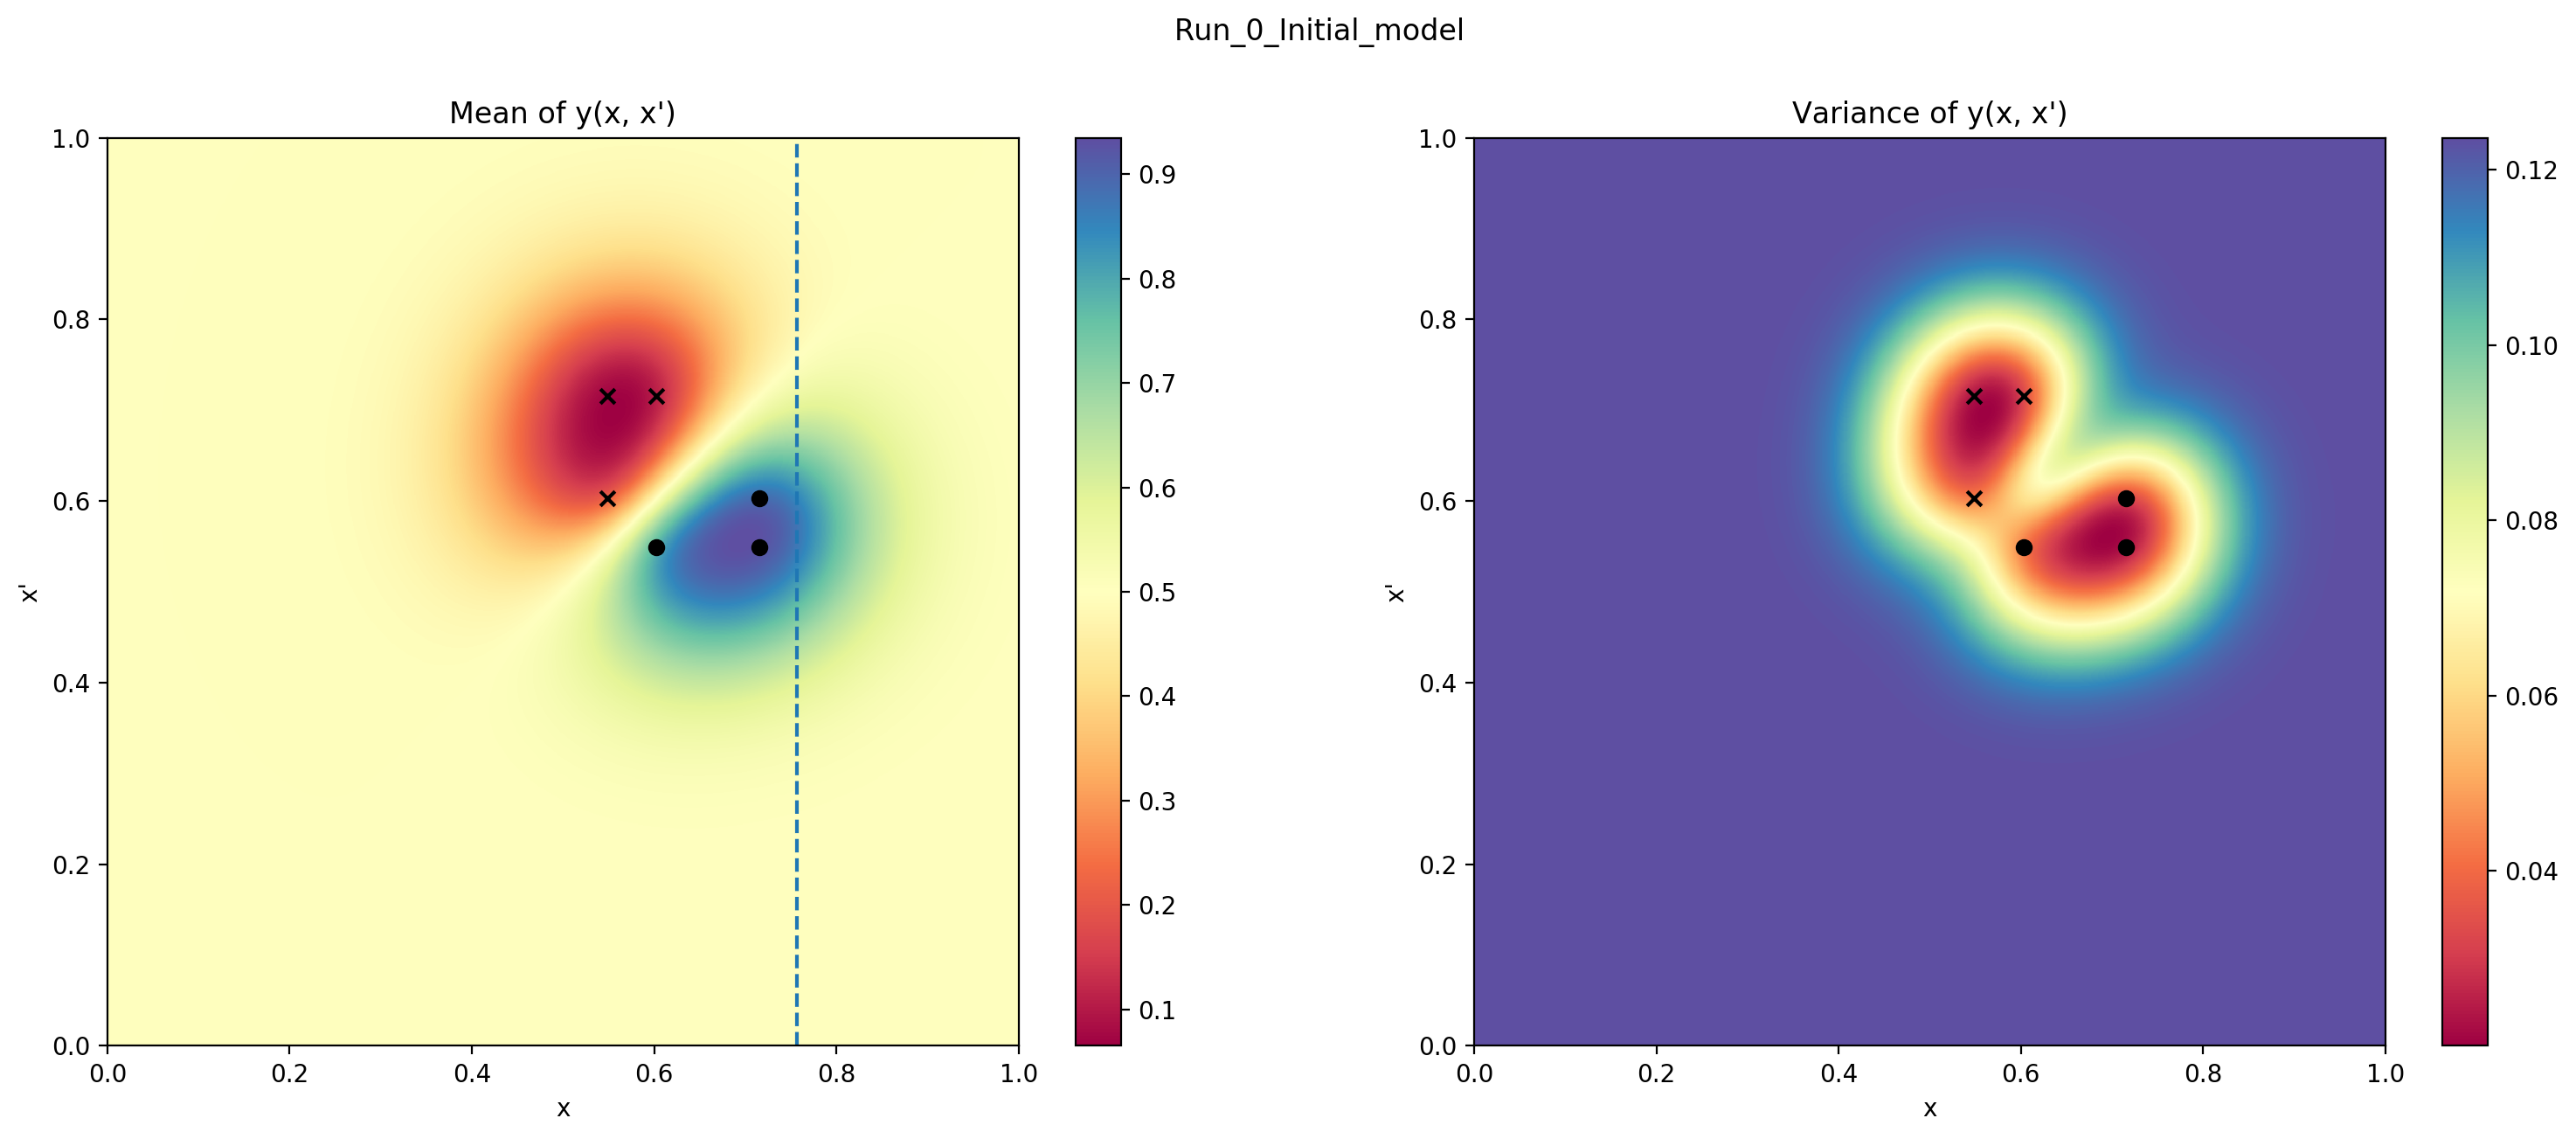

2020-03-06 19:04:41.123436: Starting evaluation 0


AttributeError: 'Product' object has no attribute 'lengthscale'

In [18]:
for run in range(num_runs):
    #Fit a GP with kernel k to Dn
    
    X = init_vals[run]
    y = get_noisy_observation_dts(X, objective)
    
    X = np.vstack([X, flip(X)])
    y = np.vstack([y, flip_y(y)])
    
    model = train_and_visualize(X, y, lengthscale=0.1, title="Run_{}_Initial_model".format(run))  #TODO: CHECK LENGTHSCALE
    
    for evaluation in range(num_evals):
        log("Starting evaluation " + str(evaluation))
        
        # Sample f using RFF
        model.likelihood = gpflow.likelihoods.Gaussian()
        f_vals = PBO.acquisitions.dts.sample_f(model, X, combs)

        # 2 and 3. Compute the acquisition for duels alpha and get next duel
        log("Computing acquisition function")
        x_next = PBO.acquisitions.dts.soft_copeland_maximizer(f_vals, discrete_space)        
        
        all_pairs = np.concatenate([np.tile(x_next, (num_discrete, 1)), discrete_space], axis=1)
        next_vars = np.squeeze(PBO.acquisitions.dts.variance_logistic_f(model, all_pairs), 
                               axis=1)
        xprime_next = discrete_space[np.argmax(next_vars)]
        
        x_xprime_next = np.expand_dims(np.concatenate([x_next, xprime_next]), axis=0)
        if np.count_nonzero(x_xprime_next) == 0:
            x_xprime_next += gpflow.default_jitter()  # Otherwise Fourier features matrix becomes non-invertible
        
        log("x and x_prime: \n" + str(x_xprime_next))
        
        # 4. Run the duel and get y
        y_next = get_noisy_observation_dts(x_xprime_next, objective)
        log("y_next: \n" + str(y_next))
        
        # 5. Augment X and Y, and add symmetric points
        X = np.vstack([X, x_xprime_next, flip(x_xprime_next)])
        y = np.vstack([y, y_next, flip_y(y_next)])
        
        # Fit a GP with kernel k to Dj and learn pi(x).
        model = train_and_visualize(X, y, lengthscale=0.1, title="Run_{}_Evaluation_{}".format(run, evaluation))
        
        # Get current best guess
        best_guess_results[run, evaluation] = best_guess(model, discrete_space, combs)

    X_results[run] = X
    y_results[run] = y

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open("results/PBO_DTS_results.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()